In [ ]:
import h5py
import os
import glob
import h5py
import numpy as np
from scipy.stats import zscore
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

from scipy.stats import binned_statistic

from scipy.optimize import curve_fit  # Add this import statement
from scipy.signal import convolve2d

In [1]:
def bin_tf_to_fpp(x, power, bin_count):
    if x.ndim == 1:  # Handle the case when x is of size (2)
        bin_ranges = np.arange(x[0], x[1], 1)
        fpp = binned_statistic(bin_ranges, power[:, x[0]:x[1]], 'mean', bins=bin_count)[0]
        fpp = np.expand_dims(fpp, axis=0)  # Add an extra dimension to match the desired output shape
    elif x.ndim == 2:  # Handle the case when x is of size (n, 2)
        fpp = []
        for i in range(x.shape[0]):
            bin_ranges = np.arange(x[i, 0], x[i, 1], 1)
            fpp_row = binned_statistic(bin_ranges, power[:, x[i, 0]:x[i, 1]], 'mean', bins=bin_count)[0]
            fpp.append(fpp_row)
        fpp = np.array(fpp)
    else:
        raise ValueError("Invalid size for x")

    return fpp


    return x_spectrum

Processing file: E:\Donders\rat1_pfc\processed\CN\post_trial5_2017-09-28_14-55-18\post_trial5_2017-09-28_14-55-18_REM_dict.h5
Available groups: ['post_trial5_2017-09-28_14-55-18']
The shape of wavelet_transform for REM 1 is: (120, 230000)
shape power matrix: (120, 230000)
(83, 120, 19)
(120, 83)
The shape of wavelet_transform for REM 10 is: (120, 280000)
shape power matrix: (120, 280000)
(119, 120, 19)
(120, 119)
The shape of wavelet_transform for REM 11 is: (120, 227500)
shape power matrix: (120, 227500)
(72, 120, 19)
(120, 72)
The shape of wavelet_transform for REM 12 is: (120, 277500)
shape power matrix: (120, 277500)
(137, 120, 19)
(120, 137)
The shape of wavelet_transform for REM 13 is: (120, 85000)
shape power matrix: (120, 85000)
(60, 120, 19)
(120, 60)
The shape of wavelet_transform for REM 14 is: (120, 50000)
shape power matrix: (120, 50000)
(24, 120, 19)
(120, 24)
The shape of wavelet_transform for REM 15 is: (120, 255000)
shape power matrix: (120, 255000)
(107, 120, 19)
(120

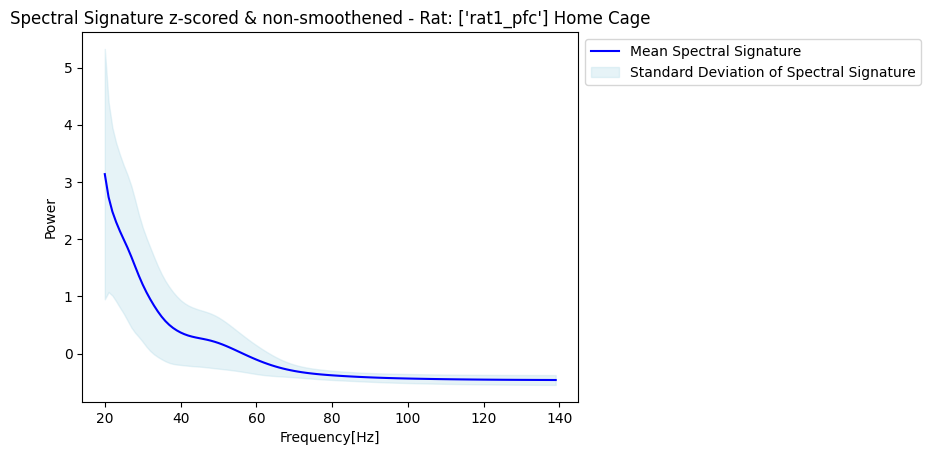

In [2]:
# Define the root folder containing '1', '3','4', '6', '9', '11', '13' folders
root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['rat1_pfc']
frequencies = np.arange(20, 140, 1)
power_list = []

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory and contains "HC"
        if os.path.isdir(subfolder_path):
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))

                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                                                        # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                # Print debugging information
                                print(f"Processing file: {hdf5_file_path}")
                                print(f"Available groups: {list(hdf_file.keys())}")
                                current_group = hdf_file[group_name]
                                
                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())
                             

                                for rem_key in rem_dict_keys:
                                    # Access the 'wavelet_transform' key for the current REM period
                                    wavelet_transform = hdf_file[group_name][rem_key]['wavelet_transform'][:]
                                    print(f"The shape of wavelet_transform for {rem_key} is: {wavelet_transform.shape}")

                                    # Square each value in the matrix to get power
                                    power_matrix = np.power(wavelet_transform, 2)
                                    print("shape power matrix:", power_matrix.shape)

                                    # Z-score along the frequency axis
                                    power = zscore(power_matrix, axis=0)
                                    #shifted_power = power + np.abs(np.min(power))
                                    #power=power_matrix
                                    #smoothed_power = boxcar_smooth(power, (5, 21))
                                    start_end = hdf_file[group_name][rem_key]['start-end'][:]
                                    fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                                    newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                                    # Calculate mean power values for the subset of frequencies
                                    fpp_plots = bin_tf_to_fpp(newcycles, power, 19)
                                    print(fpp_plots.shape)
                                    # Check if fpp_plots is 1D before attempting to calculate the mean along axis 2
                                    if len(fpp_plots.shape) > 1:
                                        mean_along_axis_2 = (np.mean(fpp_plots, axis=2)).T
                                        print(mean_along_axis_2.shape)
                                        power_list.append(mean_along_axis_2)
                                    else:
                                        # Handle the case where fpp_plots is 1D (e.g., if there's an issue with the data)
                                        print("Error: fpp_plots is 1D. Check your data.")
                                    #mean_along_axis_2 = (np.mean(fpp_plots, axis=2)).T
                                    #print(mean_along_axis_2.shape)
                                    #power_list.append(mean_along_axis_2)
            

# Replace the original list comprehension for filtered_power_list
filtered_power_list = [arr for arr in power_list if len(arr.shape) > 0]

# Concatenate the filtered arrays
power_array = np.concatenate(filtered_power_list, axis=1)
print(power_array.shape)

# Calculate the mean power across all cycles
spectral_signature_mean = np.mean(power_array, axis=1)

# Calculate the standard deviation across all cycles (instead of standard error of the mean)
spectral_signature_std = np.std(power_array, axis=1)

# Plot the mean power across all cycles
plt.plot(frequencies, spectral_signature_mean, linestyle='-', color='blue', label='Mean Spectral Signature')

# Fill the area between mean - std and mean + std with a translucent color
plt.fill_between(frequencies, spectral_signature_mean - spectral_signature_std, spectral_signature_mean + spectral_signature_std, color='lightblue', alpha=0.3, label='Standard Deviation of Spectral Signature')

plt.xlabel('Frequency[Hz]')
plt.ylabel('Power')
plt.title(f'Spectral Signature z-scored & non-smoothened - Rat: {target_folders}')
# Place the legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

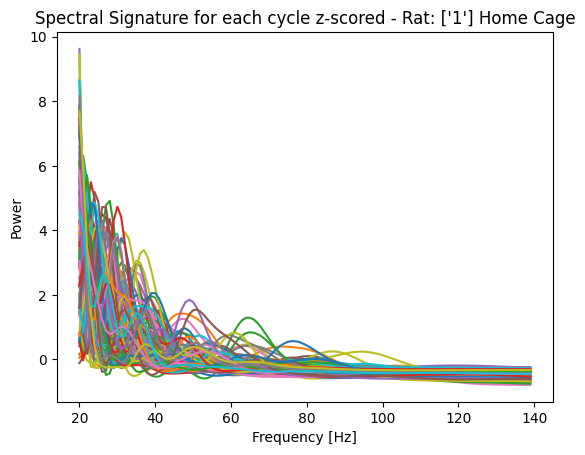

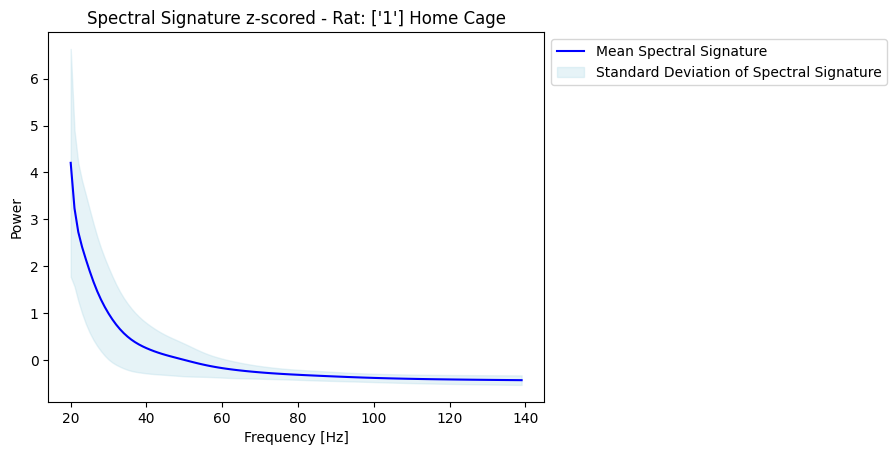

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming power_array is defined
# power_array = ...

# Assuming frequencies is defined
# frequencies = ...

# Plot each row in one plot
for i in range(power_array.shape[0]):
    plt.plot(frequencies, power_array.T[i, :], label=f'Row {i + 1}')

# Add labels and legend
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title(f'Spectral Signature for each cycle z-scored - Rat: {target_folders} Home Cage')

# Show the plot

plt.show()

# Calculate the mean power across all cycles
spectral_signature_mean = np.mean(power_array.T, axis=0)

# Calculate the standard deviation across all cycles (instead of standard error of the mean)
spectral_signature_std = np.std(power_array.T, axis=0)

# Plot the mean power across all cycles
plt.plot(frequencies, spectral_signature_mean, linestyle='-', color='blue', label='Mean Spectral Signature')

# Fill the area between mean - std and mean + std with a translucent color
plt.fill_between(frequencies, spectral_signature_mean - spectral_signature_std, spectral_signature_mean + spectral_signature_std, color='lightblue', alpha=0.3, label='Standard Deviation of Spectral Signature')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title(f'Spectral Signature z-scored - Rat: {target_folders} Home Cage')

# Place the legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

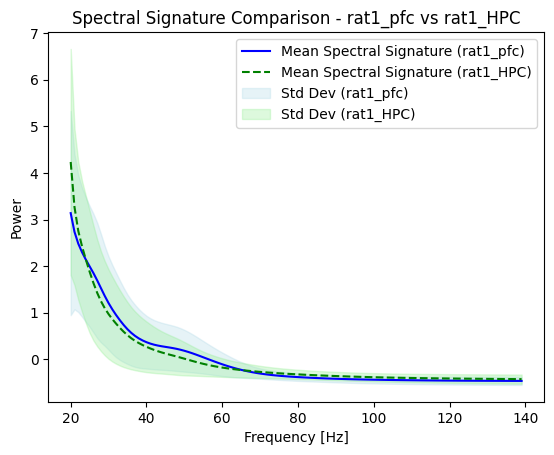

In [4]:
# Define the root folder containing '1', '3','4', '6', '9', '11', '13' folders
root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['rat1_pfc', 'rat1_HPC']  # Add 'rat1_HPC' to the target folders
frequencies = np.arange(20, 140, 1)
power_list_pfc = []  # Separate power lists for 'rat1_pfc' and 'rat1_HPC'
power_list_hpc = []

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory and contains "HC"
        if os.path.isdir(subfolder_path):
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))

                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                current_group = hdf_file[group_name]
                                
                                rem_dict_keys = list(current_group.keys())

                                for rem_key in rem_dict_keys:
                                    wavelet_transform = hdf_file[group_name][rem_key]['wavelet_transform'][:]
                                    power_matrix = np.power(wavelet_transform, 2)
                                    power = zscore(power_matrix, axis=0)
                                    start_end = hdf_file[group_name][rem_key]['start-end'][:]
                                    fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                                    newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                                    fpp_plots = bin_tf_to_fpp(newcycles, power, 19)

                                    # Check if fpp_plots is 1D before attempting to calculate the mean along axis 2
                                    if len(fpp_plots.shape) > 1:
                                        mean_along_axis_2 = (np.mean(fpp_plots, axis=2)).T
                                        if target_folder == 'rat1_pfc':
                                            power_list_pfc.append(mean_along_axis_2)
                                        elif target_folder == 'rat1_HPC':
                                            power_list_hpc.append(mean_along_axis_2)
                                        else:
                                            print("Unknown target folder.")
                                    else:
                                        print("Error: fpp_plots is 1D. Check your data.")

# Replace the original list comprehension for filtered_power_list
filtered_power_list_pfc = [arr for arr in power_list_pfc if len(arr.shape) > 0]
filtered_power_list_hpc = [arr for arr in power_list_hpc if len(arr.shape) > 0]

# Concatenate the filtered arrays
power_array_pfc = np.concatenate(filtered_power_list_pfc, axis=1)
power_array_hpc = np.concatenate(filtered_power_list_hpc, axis=1)

# Calculate the mean power across all cycles for both 'rat1_pfc' and 'rat1_HPC'
spectral_signature_mean_pfc = np.mean(power_array_pfc, axis=1)
spectral_signature_mean_hpc = np.mean(power_array_hpc, axis=1)

# Calculate the standard deviation across all cycles for both 'rat1_pfc' and 'rat1_HPC'
spectral_signature_std_pfc = np.std(power_array_pfc, axis=1)
spectral_signature_std_hpc = np.std(power_array_hpc, axis=1)

# Plot the mean power across all cycles for both 'rat1_pfc' and 'rat1_HPC'
plt.plot(frequencies, spectral_signature_mean_pfc, linestyle='-', color='blue', label='Mean Spectral Signature (rat1_pfc)')
plt.plot(frequencies, spectral_signature_mean_hpc, linestyle='--', color='green', label='Mean Spectral Signature (rat1_HPC)')

# Fill the area between mean - std and mean + std with a translucent color for 'rat1_pfc'
plt.fill_between(frequencies, spectral_signature_mean_pfc - spectral_signature_std_pfc, spectral_signature_mean_pfc + spectral_signature_std_pfc, color='lightblue', alpha=0.3, label='Std Dev (rat1_pfc)')

# Fill the area between mean - std and mean + std with a translucent color for 'rat1_HPC'
plt.fill_between(frequencies, spectral_signature_mean_hpc - spectral_signature_std_hpc, spectral_signature_mean_hpc + spectral_signature_std_hpc, color='lightgreen', alpha=0.3, label='Std Dev (rat1_HPC)')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Spectral Signature Comparison - rat1_pfc vs rat1_HPC')
plt.legend()
plt.show()
